In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
'''
加载预训练的ResNet-18模型
加载了一个在ImageNet数据集上预训练的ResNet-18模型
'''
pretrained_net = torchvision.models.resnet18(pretrained=True)

C:\Users\13498\anaconda3\envs\mul\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\13498\anaconda3\envs\mul\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
'''
将模型的子模块（layers）转换成列表，并打印出最后三个子模块
'''
list(pretrained_net.children())[-3:]

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [4]:
'''
去掉ResNet-18的最后两个模块，构建新的网络

- `list(pretrained_net.children())[:-2]` 
    将预训练模型的子模块列表中去掉最后两个模块
    （通常是全连接层和全局平均池化层）。
- `nn.Sequential(*list(pretrained_net.children())[:-2])` 
    使用去掉最后两个模块后的子模块列表构建一个新的网络`net`。
    `nn.Sequential` 用于将多个模块串联起来，按顺序执行。

星号（`*`）运算符在函数调用中有特殊的用法，
称为“解包”操作。它可以将一个列表或元组解包成单独的元素。
'''
net = nn.Sequential(
    *list(
        pretrained_net.children()
    )[:-2]
)

In [5]:
'''
创建一个随机输入张量，并通过新构建的网络
'''
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [6]:
num_classes = 21
'''
添加新的卷积层和反卷积层
- `net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))`：
  - 这里添加了一个新的卷积层 `final_conv` 到 `net` 网络中。
  这个卷积层将输入通道数从 512 变为 `num_classes`（21），并使用 1x1 的卷积核。
  - 1x1 卷积用于改变通道数，通常用于分类任务中将特征图转化为所需的类别数量。

'''
net.add_module(
    'final_conv', 
    nn.Conv2d(512, num_classes, kernel_size=1)
)
'''
- `net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32))`：
  - 这里添加了一个转置卷积层（也称为反卷积层） `transpose_conv`，
  将输入特征图上采样。
  - 该层的输入和输出通道数均为 `num_classes`（21），
  卷积核大小为 64，填充为 16，步幅为 32。
  - 反卷积层用于将低分辨率的特征图上采样到更高分辨率，
  

'''
net.add_module(
    'transpose_conv',
    nn.ConvTranspose2d(
        num_classes, 
        num_classes,
        kernel_size=64,
        padding=16,
        stride=32
    )
)

初始化转置卷积层

In [7]:
'''
双线性插值核函数
- `factor` 用于计算卷积核中心的位置。
- `og` 生成一个包含卷积核坐标的网格。
- `filt` 计算插值核的值。
- `weight` 初始化一个大小为
`(in_channels, out_channels, kernel_size, kernel_size)` 的全零张量，
并将每个通道的插值核赋值给相应位置。
- 最终返回生成的权重张量。
'''
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor -1
    else:
        center = factor - 0.5
    og = (
        torch.arange(kernel_size).reshape(-1, 1),
        torch.arange(kernel_size).reshape(1, -1)
    )
    filt = (
        1 - torch.abs(og[0] - center) / factor
    ) * \
    (
        1 - torch.abs(og[1] - center) / factor
    )

    weight = torch.zeros(
        (
            in_channels, 
            out_channels,
            kernel_size,
            kernel_size
        )
    )

    weight[range(in_channels),range(out_channels),:,:] = filt

    return weight

In [8]:
'''
初始化转置卷积层的权重

- 这里定义了一个新的转置卷积层 `conv_trans`，
其输入和输出通道数均为 3，卷积核大小为 4，填充为 1，步幅为 2，并且没有偏置项。
- 使用前面定义的 `bilinear_kernel` 函数生成双线性插值核，
并将其赋值给 `conv_trans` 的权重。

'''
conv_trans = nn.ConvTranspose2d(
    3, 3, kernel_size=4, padding=1, stride=2, bias=False
)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4))

tensor([[[[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0625, 0.1875, 0.1875, 0.0625],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.1875, 0.5625, 0.5625, 0.1875],
          [0.0625, 0.1875, 0.1875, 0.0625]],

         [[0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0

In [9]:
img = torchvision.transforms.ToTensor()(
    d2l.Image.open('./img/catdog.jpg')
)
'''
为张量增加一个维度，以便其形状为 `(1, 3, 高度, 宽度)`，符合网络输入的要求
'''
X = img.unsqueeze(0)
Y = conv_trans(X)
'''
 将输出张量的维度调整为 `(高度, 宽度, 3)` 并分离计算图，以便于后续可视化
'''
out_img = Y[0].permute(1, 2, 0).detach()

input image shape:  torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


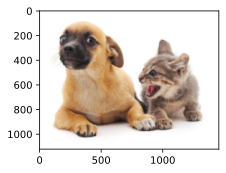

In [10]:
d2l.set_figsize()
print('input image shape: ', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0))
print("output image shape:", out_img.shape)
d2l.plt.imshow(out_img)

In [11]:
'''
初始化转置卷积层的权重

- `W = bilinear_kernel(num_classes, num_classes, 64)`：
生成一个 `num_classes x num_classes` 大小、卷积核大小为 64 的双线性插值核。

- `net.transpose_conv.weight.data.copy_(W)`：
将生成的双线性插值核 `W` 复制到 `transpose_conv` 转置卷积层的权重中。
这确保了转置卷积层在初始化时使用双线性插值的方式进行上采样。

'''
W = bilinear_kernel(
    num_classes,
    num_classes,
    64
)
net.transpose_conv.weight.data.copy_(W)

tensor([[[[0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          ...,
          [0.0012, 0.0037, 0.0061,  ..., 0.0061, 0.0037, 0.0012],
          [0.0007, 0.0022, 0.0037,  ..., 0.0037, 0.0022, 0.0007],
          [0.0002, 0.0007, 0.0012,  ..., 0.0012, 0.0007, 0.0002]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

读取数据集

In [12]:
'''
加载和处理 VOC 数据集
- `batch_size = 32` 和 `crop_size = (320, 480)`：
定义批量大小和裁剪后的图像尺寸。
- `train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)`：
加载和预处理 VOC 数据集，返回训练和测试迭代器。

'''
batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


训练

In [13]:
'''
定义损失函数

- 定义一个自定义的损失函数。
`F.cross_entropy(inputs, targets, reduction='none')` 
计算交叉熵损失，但不进行任何维度的求和或平均。
- `mean(1).mean(1)`：对第 1 维和第 1 维（即高度和宽度）进行平均。

'''
def loss(inputs, targets):
    return F.cross_entropy(
        inputs, targets, reduction='none'
    ).mean(1).mean(1)

loss 0.420, train acc 0.868, test acc 0.852
208.9 examples/sec on [device(type='cuda', index=0)]


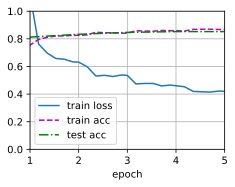

In [14]:
'''
设置训练参数并进行训练
'''
num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(
    net.parameters(),
    lr=lr,
    weight_decay=wd
)
d2l.train_ch13(
    net, train_iter, test_iter, loss, trainer, num_epochs, devices
)

In [15]:
'''
定义预测函数
- `X = test_iter.dataset.normalize_image(img).unsqueeze(0)`：
对输入图像进行标准化，并增加一个维度以匹配模型输入。
- `pred = net(X.to(devices[0])).argmax(dim=1)`：
将图像传入模型，预测每个像素的类别，并在类别维度上取最大值的索引。
- `return pred.reshape(pred.shape[1], pred.shape[2])`：
返回预测结果，并调整形状以匹配图像的高度和宽度。

'''
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [16]:
'''
定义将预测标签转换为图像的函数
- `colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])`：
获取 VOC 数据集的颜色映射表，并将其转换为张量。
- `X = pred.long()`：
将预测结果转换为长整型。
- `return colormap[X, :]`：
使用颜色映射表将预测标签转换为图像。

'''
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

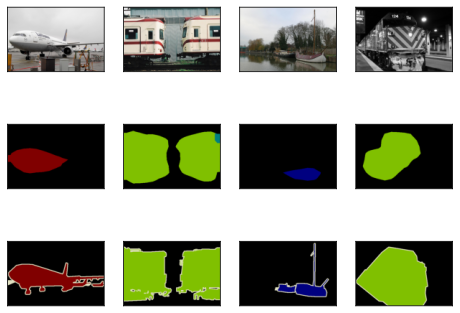

In [17]:
'''
测试和可视化
- `voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')`：
下载并解压 VOC2012 数据集。
- `test_images, test_labels = d2l.read_voc_images(voc_dir, False)`：
读取测试图像和标签。
- `n, imgs = 4, []`：
定义显示的图像数量 `n` 和一个空列表 `imgs`。
- 循环处理 `n` 张测试图像：
  - `crop_rect = (0, 0, 320, 480)`：定义裁剪区域。
  - `X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)`：
  裁剪图像。
  - `pred = label2image(predict(X))`：
  对裁剪后的图像进行预测，并将预测结果转换为图像。
  - `imgs += [X.permute(1,2,0), pred.cpu(), torchvision.transforms.functional.crop(test_labels[i], *crop_rect).permute(1,2,0)]`：
  将输入图像、预测结果和真实标签添加到 `imgs` 列表中。
- `d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2)`：
显示 `n` 张图像，按顺序显示输入图像、预测结果和真实标签。

'''
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(
        test_images[i], *crop_rect
    )
    pred = label2image(predict(X))
    imgs += [
        X.permute(1, 2, 0),
        pred.cpu(),
        torchvision.transforms.functional.crop(
            test_labels[i],
            *crop_rect
        ).permute(1, 2, 0)
    ]

d2l.show_images(
    imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2
)